In [ ]:
import spacy
from spacy import displacy
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
text = "Who are you talking to right now? Who is it you think you see? Do you know how much I make a year? I mean, even if I told you, you wouldn’t believe it. Do you know what would happen if I suddenly decided to stop going into work? A business big enough that it could be listed on the NASDAQ goes belly up. Disappears! It ceases to exist without me. No, you clearly don’t know who you’re talking to, so let me clue you in. I am not in danger, Skyler. I am the danger. A guy opens his door and gets shot and you think that of me? No. I am the one who knocks!"

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
doc = nlp(text)

In [ ]:
for ent in doc.ents:
    print(ent.text, ent.label_)

a year DATE
NASDAQ ORG
Skyler PERSON


In [ ]:
displacy.render(doc, style='ent', jupyter=True, options={'distance': 90})

In [ ]:
tokens = text.split()
tokens[:10]
print(len(tokens))

117


In [104]:
n_grams = [([tokens[i-1], tokens[i + 1]], tokens[i])
  for i in range(1, len(tokens) - 2)]
n_grams[:3]

[(['Who', 'you'], 'are'),
 (['are', 'talking'], 'you'),
 (['you', 'to'], 'talking')]

In [105]:
vocab = set(tokens)
len(vocab)

85

In [106]:
class NGramLanguageModeler(nn.Module):
  def __init__(self, vocab_size, embedding_dim, context_size):
    super(NGramLanguageModeler, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.linear1 = nn.Linear(context_size * embedding_dim, 128)
    self.linear2 = nn.Linear(128, vocab_size)

  def forward(self, inputs):
    embeds = self.embeddings(inputs).view((1, -1))
    out = F.relu(self.linear1(embeds))
    out = self.linear2(out)
    log_probs = F.log_softmax(out, dim=1)
    return log_probs

In [108]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 3

In [109]:
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [110]:
losses = []
acc=[]
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [111]:
for epoch in range(1000):
    total_loss = 0
    num_correct = 0
    num_examples = 0
    for context, target in n_grams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        model.zero_grad()
        log_probs = model(context_idxs)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        loss.backward()
        optimizer.step()
        
        topv, topi = log_probs.topk(1)
        prediction = topi.item()

        if prediction == word_to_ix.get(target):
            num_correct += 1
        num_examples += 1

        total_loss += loss.item()
        
    train_loss = total_loss / len(n_grams)
    train_acc = (num_correct / num_examples)*100
    
    losses.append(train_loss)
    acc.append(train_acc)

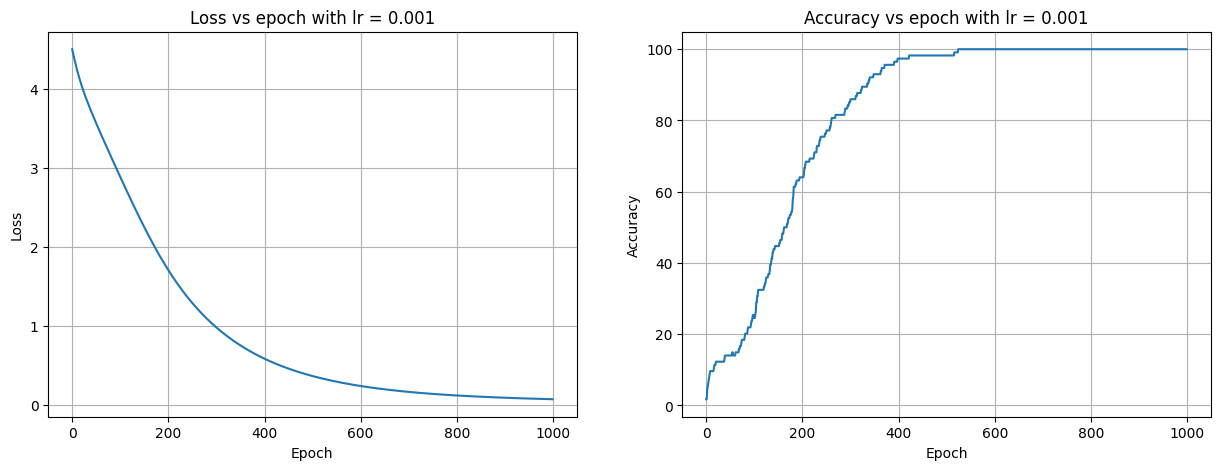

In [112]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 5)

plt.subplot(1, 2, 1)
plt.title("Loss vs epoch with lr = 0.001")
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.xticks(np.arange(0, 1001, 100))
plt.plot(losses)
plt.grid()

plt.subplot(1, 2, 2)
plt.title("Accuracy vs epoch with lr = 0.001")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.xticks(np.arange(0, 1001, 100))
plt.plot(acc)
plt.grid()

plt.show()

In [113]:
with torch.no_grad():
    total_loss = 0
    num_correct = 0
    num_examples = 0
    for context, target in n_grams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        log_probs = model(context_idxs)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        total_loss += loss.item()
        
        topv, topi = log_probs.topk(1)
        prediction = topi.item()

        if prediction == word_to_ix.get(target):
            num_correct += 1
        num_examples += 1
        
    test_loss = total_loss / len(n_grams)
    test_acc = (num_correct / num_examples)*100
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0683 | Test Accuracy: 100.0000


In [114]:
with torch.no_grad():
    context = ['Who', 'you']
    context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
    log_probs = model(context_idxs)
    predicted_word = [k for k, v in word_to_ix.items() if v == torch.argmax(log_probs).item()] 

    print("Context:", context)
    print("Predicted word:", predicted_word)

Context: ['Who', 'you']
Predicted word: ['are']
